In [15]:
import torch 
import torch.autograd as autograd   #computation graph
from torch import Tensor            #tensor node in the computation graph
import torch.nn as nn               #neural network
import torch.optim as optim         #optimizers e.g. gradient descent , ADAM, etc

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs  #Latin Hypercube Sampling

#set default dtype to float32
torch.set_default_dtype(torch.float)

#pyTorch random number generator
torch.manual_seed(1234)

#andom number generator in other libraries
np.random.seed(1234)

#device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())






cuda:0


In [16]:
def plot3D(x,t,y):
    x_plot = x
    t_plot = t
    X,T = torch.meshgrid(x_plot,t_plot)
    F_xt = y
    fig, ax = plt.subplots(1,1)
    cp = ax.contourf(T,X,F_xt,20, cmap = "rainbow") #contour plot with 20 layers?
    fig.colorbar(cp) #add a colorbar to the plot
    ax.set_title('F(x,t)')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection = '3d')
    ax.plot_surface(T.numpy(),X.numpy(), F_xt.numpy(), cmap="rainbow")
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('f(x,t)')
    plt.show()

    
    

In [17]:
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [18]:
steps=20000
lr=1e-3
layers = np.array([2,32,32,1]) # hidden layers
# To generate new data:
x_min=-1
x_max=1
t_min=0
t_max=1
total_points_x=200
total_points_t=100
#Nu: Number of training points # Nf: Number of collocation points (Evaluate PDE)
Nu=100
Nf=10000


In [19]:
def f_real(x,t):
    return torch.exp(-t)*torch.sin(np.pi*x)


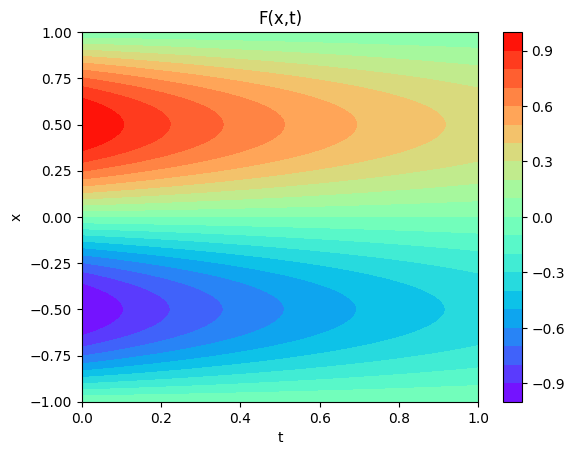

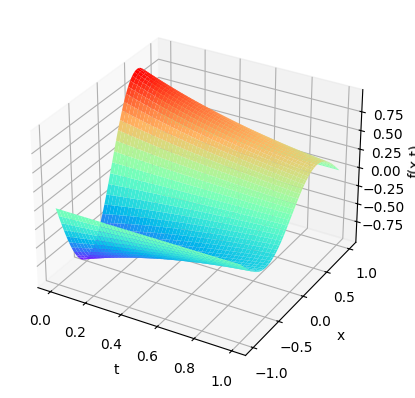

In [20]:
x = torch.linspace(-1,1,200)
t = torch.linspace(0,1,100)
X,T = torch.meshgrid(x,t)
y_real = f_real(X,T)
plot3D(x,t,y_real)


In [23]:
x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test = y_real.transpose(1,0).flatten()[:,None]

lb = x_test[0]
ub = x_test[-1]

print(x_test.shape, y_test.shape)
print(lb,ub)

torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([-1.,  0.]) tensor([1., 1.])


Training Data

In [24]:
left_x = torch.hstack((X[:,0][:,None], T[:,0][:,None]))
left_y = torch.sin(np.pi*left_x[:,0]).unsqueeze(1)

bottom_x = torch.hstack((X[-1,:][:,None], T[-1,:][:,None]))
bottom_y = torch.zeros(bottom_x.shape[0],1)

top_x = torch.hstack((X[0,:][:,None], T[0,:][:,None]))
top_y = torch.zeros(top_x.shape[0],1)

X_train = torch.vstack([left_x,bottom_x,top_x])
Y_train = torch.vstack([left_y,bottom_y,top_y])

Nu =100
idx = np.random.choice(X_train.shape[0],Nu,replace=False)

X_train_Nu = X_train[idx,:]
Y_train_Nu = Y_train[idx,:]

#collocation pts

X_train_Nf = lb +(ub-lb)*lhs(2,Nf)

X_train_Nf = torch.vstack((X_train_Nf, X_train_Nu))


In [25]:
X_train_Nu = X_train_Nu.float().to(device)
Y_train_Nu = Y_train_Nu.float().to(device)
X_train_Nf = X_train_Nf.float().to(device)
f_hat = torch.zeros(X_train_Nf.shape[0],1).to(device)




Neural Network


In [26]:
class FCN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.activation = nn.Tanh()
        self.loss_function =nn.MSELoss(reduction = "mean")
        self.linears = nn.ModuleList([nn.Linear(layers[i],layers[i+1]) for i in range(len(layers)-1)])
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)
    
    def forward(self,x):
        if torch.is_tensor(x) != True:
            x =torch.from_numpy(x)
        
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        
        a = self.linears[-1](a)
        return a

    def lossBC(self,x_BC,y_BC):
        loss_BC = self.loss_function(self.forward(x_BC), y_BC)
        return loss_BC

    def lossPDE(self, x_PDE):
        g = x_PDE.clone()
        g.requires_grad = True
        f = self.forward(g)
        f_x_t = autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph = True, create_graph = True)[0]
        f_xx_tt = autograd.grad(f_x_t,g,torch.ones(g.shape).to(device), create_graph = True)[0]
        f_t = f_x_t[:,[1]]
        f_xx = f_xx_tt[:,[0]]
        f = f_t - f_xx + torch.exp(-g[:,1:])*(torch.sin(np.pi*g[:,0:1])-np.pi**2*torch.sin(np.pi*g[:,0:1]))
        return self.loss_function(f,f_hat)
    
    def loss(self,x_BC, y_BC,x_PDE):
        loss_bc = self.lossBC(x_BC,y_BC)
        loss_pde = self.lossPDE(x_PDE)
        return loss_bc + loss_pde
        

    


        

In [27]:
layers = np.array([2,32,64,1])
PINN = FCN(layers)

PINN.to(device)
print(PINN)

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [28]:
optimizer = torch.optim.Adam(PINN.parameters(),lr= 1e-3,amsgrad = False)

In [29]:
x_test, y_test = x_test.to(device), y_test.to(device)

In [30]:
for i in range(20000):
    loss = PINN.loss(X_train_Nu,Y_train_Nu, X_train_Nf)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if i%(20000/10) == 0:
        with torch.no_grad():
            test_loss = PINN.lossBC(x_test, y_test)
        print("training:",loss,"/Testing",test_loss)

training: tensor(16.8809, device='cuda:0', grad_fn=<AddBackward0>) /Testing tensor(0.1762, device='cuda:0')
training: tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>) /Testing tensor(0.0427, device='cuda:0')
training: tensor(0.0008, device='cuda:0', grad_fn=<AddBackward0>) /Testing tensor(0.0381, device='cuda:0')
training: tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>) /Testing tensor(0.0372, device='cuda:0')
training: tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>) /Testing tensor(0.0370, device='cuda:0')
training: tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>) /Testing tensor(0.0361, device='cuda:0')
training: tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>) /Testing tensor(0.0364, device='cuda:0')
training: tensor(8.2601e-05, device='cuda:0', grad_fn=<AddBackward0>) /Testing tensor(0.0367, device='cuda:0')
training: tensor(7.0181e-05, device='cuda:0', grad_fn=<AddBackward0>) /Testing tensor(0.0366, device='cuda:0')
training: tensor(6.0665e-05,

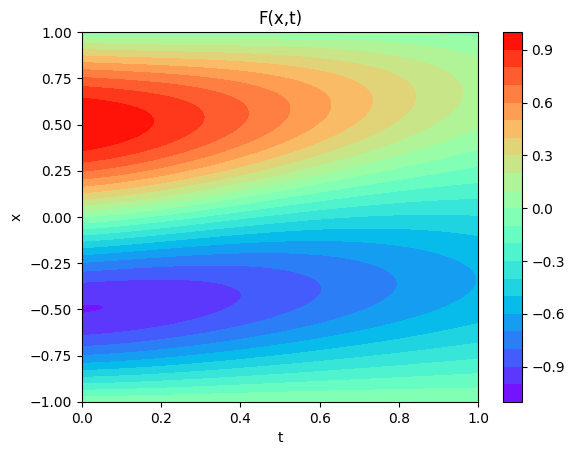

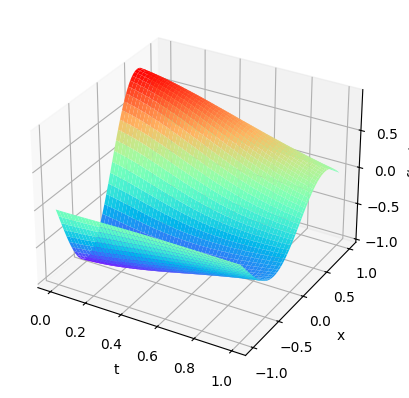

In [31]:

y1=PINN(x_test)

x1=x_test[:,0]
t1=x_test[:,1]
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()


plot3D_Matrix(arr_x1,arr_T1,arr_y1)
     